First we need to import some libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from geotext import GeoText

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *
from tmv_app.views import *

now=datetime.datetime.now()

then we set the project and query we are interested in

In [2]:
pid = 217
qid = 7966
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

Now we get a list of the ones we've seen

In [3]:
seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))
print(len(seen))

3000


We also get a full list of docs in the climate change query and in this query

In [4]:
climate_docs = set(Doc.objects.filter(query=6187).values_list('pk',flat=True))
q_set = set(q.doc_set.values_list('pk',flat=True))

print(f"query docs: {len(q_set)}")
print(f"climate docs: {len(climate_docs)}")

query docs: 94944
climate docs: 407957


We look at the topic on adaptation and get the doc-topic scores for all the documents

In [5]:
t = Topic.objects.get(pk=170476)
print(t)
dts = DocTopic.objects.filter(topic=t)
dtdf = pd.DataFrame.from_dict(list(dts.values('doc__id','score')))
print(dtdf.shape)
dtdf.head()

adaptation, adaptation & vulnerability
(116894, 2)


,doc__id,score
0,321191,0.000559
1,680604,0.000777
2,517208,0.000239
3,4025,0.000112
4,365998,0.000585


We also want to include the documents that don't have an adapation topic score and call the score 0

In [6]:
unadapt = climate_docs - set(dtdf['doc__id'])
udf = pd.DataFrame({"doc__id": list(unadapt)})
dtdf = dtdf.merge(udf,how="outer").fillna(0)
dtdf.head()

,doc__id,score
0,321191,0.000559
1,680604,0.000777
2,517208,0.000239
3,4025,0.000112
4,365998,0.000585


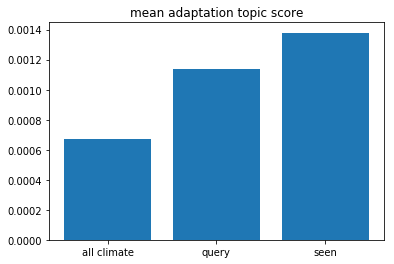

In [7]:
fig, ax = plt.subplots()
ax.bar(
    [1,2,3],
    [
        dtdf.score.mean(), 
        dtdf[dtdf['doc__id'].isin(q_set)].score.mean(), 
        dtdf[dtdf['doc__id'].isin(seen)].score.mean()
    ]
)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['all climate','query', 'seen'])

ax.set_title('mean adaptation topic score')


In [8]:
rows = []
for d in Doc.objects.filter(query=6187):
    cities = set(GeoText(f"{d.content} {d.title}").cities)
    rows.append({
        "doc__id": d.id,
        "cities": len(cities)>0
    })
ddf = pd.DataFrame.from_dict(rows)

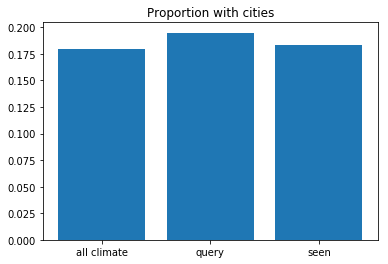

In [9]:
fig, ax = plt.subplots()
ax.bar(
    [1,2,3],
    [
        ddf.cities.mean(), 
        ddf[ddf['doc__id'].isin(q_set)].cities.mean(), 
        ddf[ddf['doc__id'].isin(seen)].cities.mean()
    ]
)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['all climate','query', 'seen'])

ax.set_title("Proportion with cities")

In [11]:
now

datetime.datetime(2020, 2, 5, 16, 55, 23, 665072)

In [14]:
tag = Tag(
    title="adaptation topic sample {}".format(now),
    query=q
)
tag.save()

max_docs = 500
docs_added = 0

for dt in dts.order_by('-score'):
    d = dt.doc
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()